In [125]:
#python program to load images to numpy array
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
#import image from pillow
import PIL
import pathlib

In [ ]:
#loading images from a folder to numpy array
#not required for this project
def load_images_from_folder(folder = r"C:\Users\Ankush Hegde\Desktop\My projects\Kavach Hackathon\images"):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
img_array = np.array(load_images_from_folder())
print(img_array[0])

In [103]:
#counting the number of jpeg and png files 
data_dir = pathlib.Path(r"C:\Users\Ankush Hegde\Desktop\My projects\Kavach Hackathon\images")
jpeg_image_count = len(list(data_dir.glob("*.jpg")))
print(jpeg_image_count)
png_image_count = len(list(data_dir.glob("*.png")))
print(png_image_count)
print(png_image_count+jpeg_image_count)

181
1902
2083


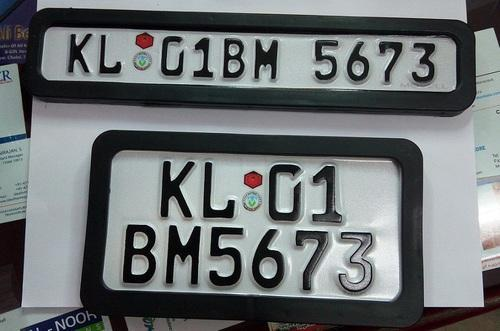

In [104]:
#opening a single image
plate = list(data_dir.glob("*.jpg"))
PIL.Image.open(str(plate[0]))

In [154]:
#defining dimensions of the image
img_height = 224
img_width = 224
batch_size = 23


In [155]:
#training the model using tensorflow
#using tensorflow to load images from a folder and spliting the datasets 
#into training and validation sets

folder = r"C:\Users\Ankush Hegde\Desktop\My projects\Kavach Hackathon\archive\State-wise_OLX"
train_ds = tf.keras.utils.image_dataset_from_directory(
    folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)



Found 602 files belonging to 35 classes.
Using 482 files for training.


In [156]:
#train the labels of the images
#plotting with matplotlib 
val_ds = tf.keras.utils.image_dataset_from_directory(
    folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 602 files belonging to 35 classes.
Using 120 files for validation.


p

In [157]:
class_names = train_ds.class_names
print(class_names)

['AN', 'AP', 'AR', 'AS', 'BR', 'CG', 'CH', 'DL', 'DN', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OD', 'PB', 'PY', 'RJ', 'SK', 'TN', 'TR', 'TS', 'UK', 'UP', 'WB']


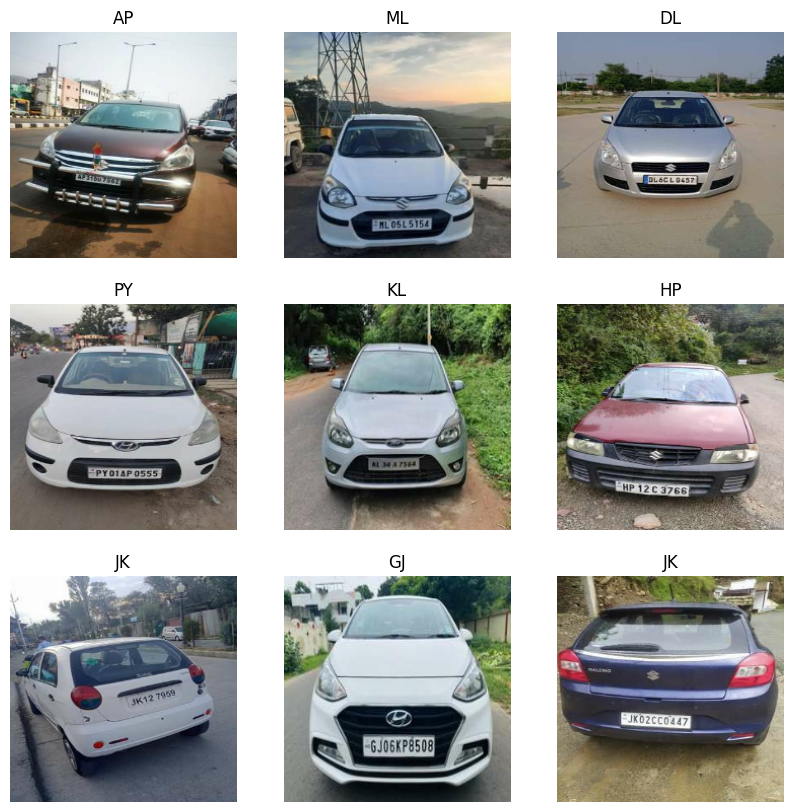

In [158]:
#plotting the images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") 




In [159]:
#storing images with labels in a list   
image_list = []
label_list = []
for images, labels in train_ds.take(1):
    for i in range(len(images)):
        image_list.append(images[i].numpy().astype("uint8"))
        label_list.append(class_names[labels[i]])
#print(image_list[0])
print(len(image_list))

23


In [160]:
#extracting the images from the list and store it in a folder
"""folder_path = r"C:\Users\Ankush Hegde\Desktop\My projects\Kavach Hackathon\test_imgs"
for i,img in enumerate(image_list):
    img_path = os.path.join(folder_path,f"image_{i}.jpg")
    cv2.imwrite(img_path,img)"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 18-19: truncated \UXXXXXXXX escape (114320181.py, line 5)

In [161]:
#normalizing the images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(23, 224, 224, 3)
(23,)


In [162]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [163]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch,labels_batch = next(iter(normalized_ds))
first_image  = image_batch[0]
print(np.min(first_image),np.max(first_image))

4.0642517e-05 1.0


In [164]:
#configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [168]:
#training the model and optimization 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
num_classes = 35
model = tf.keras.Sequential([
    #tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32,(3,3),activation=None, input_shape=(img_height, img_width, 3)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation=None),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation=None),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(num_classes)
])


In [174]:


sgd = optimizers.SGD(lr = 0.01,decay=1e-6,momentum=0.2,nesterov=True)
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [172]:
model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=10
          )

Epoch 1/10
21/21 [==============================] - 21s 1s/step - loss: 87.7613 - accuracy: 0.0581 - val_loss: 19.6351 - val_accuracy: 0.0583
Epoch 2/10
21/21 [==============================] - 20s 937ms/step - loss: 8.2115 - accuracy: 0.1660 - val_loss: 6.4395 - val_accuracy: 0.0667
Epoch 3/10
21/21 [==============================] - 19s 885ms/step - loss: 2.2614 - accuracy: 0.5000 - val_loss: 6.4164 - val_accuracy: 0.0500
Epoch 4/10
21/21 [==============================] - 18s 865ms/step - loss: 0.8464 - accuracy: 0.7676 - val_loss: 7.2228 - val_accuracy: 0.0333
Epoch 5/10
21/21 [==============================] - 18s 842ms/step - loss: 0.2042 - accuracy: 0.9523 - val_loss: 5.8929 - val_accuracy: 0.1000
Epoch 6/10
21/21 [==============================] - 18s 835ms/step - loss: 0.0356 - accuracy: 0.9959 - val_loss: 6.3545 - val_accuracy: 0.1083
Epoch 7/10
21/21 [==============================] - 17s 824ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 6.7216 - val_accuracy: 0.0917
